In [1]:
import torch.nn as nn
import torch
import numpy as np
import numpy as np
import torch.nn as nn
import torch.nn.functional as F


import torch
import torch.utils.data
import matplotlib.pyplot as plt
from utils import AvgrageMeter, make_latent_dataset
from models.autoencoder import Autoencoder
from main import train_classifier

In [2]:
def tensor_delete(tens, index, axis):
    mask = np.ones(tens.shape[axis], np.bool)
    mask[index] = 0
    indices = np.arange(tens.shape[axis])[mask]
    if len(tens.shape) == 1:
        return tens[indices]
    if axis == 0:
        return tens[indices, :]
    return tens[:, indices]

In [3]:
train_x = np.load('data/k49-train-imgs.npz')['arr_0']
train_y = np.load('data/k49-train-labels.npz')['arr_0']
test_x = np.load('data/k49-test-imgs.npz')['arr_0']
test_y = np.load('data/k49-test-labels.npz')['arr_0']

# Map to [-1, 1] so that we can use a tanh function
# train_x = (train_x / 127.5) - 1
# test_x = (test_x / 127.5) - 1

# Map to [0, 1] so that we can use a relu function
train_x = train_x / 255
test_x = test_x / 255

In [4]:
ids = np.arange(len(train_x))
np.random.shuffle(ids)

train_x = train_x[ids][:10000]
train_y = train_y[ids][:10000]

In [5]:
train_x = torch.from_numpy(train_x).type(torch.FloatTensor)
test_x = torch.from_numpy(test_x).type(torch.FloatTensor)

train_y = torch.from_numpy(train_y).type(torch.LongTensor)
test_y = torch.from_numpy(test_y).type(torch.LongTensor)

In [6]:
train = torch.utils.data.TensorDataset(train_x, train_y)
test = torch.utils.data.TensorDataset(test_x, test_y)

In [7]:
batch_size = 1024

train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test, batch_size=batch_size, shuffle=True)

In [8]:
class Autoencoder(nn.Module):
    def __init__(self, latent_size=28*28):
        self.latent_size = latent_size
        self.num_filters = [2, 3]
        super(Autoencoder, self).__init__()
        
        # Encoder
        self.conv1 = nn.Conv2d(1, self.num_filters[0], 3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(self.num_filters[0], self.num_filters[1], 3, stride=1, padding=1)
        self.fc1 = nn.Linear(self.num_filters[1] * 28 * 28, 28 * 28)
        
        
        # Decoder
        self.fc2 = nn.Linear(28 * 28, self.num_filters[1] * 28 * 28)
        self.conv3 = nn.Conv2d(self.num_filters[1], self.num_filters[0], 3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(self.num_filters[0], 1, 3, stride=1, padding=1)
        
        # Initializing the weights to make the model predict the identity
        with torch.no_grad():
            """
            filter_weights = [[0.0, 0.0, 0.0, 0.0, 0.0], 
                              [0.0, 0.0, 0.0, 0.0, 0.0], 
                              [0.0, 0.0, 1.0, 0.0, 0.0], 
                              [0.0, 0.0, 0.0, 0.0, 0.0],
                              [0.0, 0.0, 0.0, 0.0, 0.0]]
            """
            filter_weights = np.array([[0.0, 0.0, 0.0], 
                              [0.0, 1.0, 0.0], 
                              [0.0, 0.0, 0.0]])
            for i in range(1): 
                self.conv4.weight[i] = torch.nn.Parameter(torch.tensor(filter_weights.copy()))

            for i in range(self.num_filters[0]): 
                self.conv1.weight[i] = torch.nn.Parameter(torch.tensor(filter_weights.copy()))
                self.conv3.weight[i] = torch.nn.Parameter(torch.tensor(filter_weights.copy()))

            for i in range(self.num_filters[1]): 
                self.conv2.weight[i] = torch.nn.Parameter(torch.tensor(filter_weights.copy()/ self.num_filters[0])) 

            self.conv1.bias = torch.nn.Parameter(torch.zeros(self.conv1.bias.shape))
            self.conv2.bias = torch.nn.Parameter(torch.zeros(self.conv2.bias.shape))
            self.conv3.bias = torch.nn.Parameter(torch.zeros(self.conv3.bias.shape))
            self.conv4.bias = torch.nn.Parameter(torch.zeros(self.conv4.bias.shape))
            
            self.fc1.bias = torch.nn.Parameter(torch.zeros(self.fc1.bias.shape))
            self.fc2.bias = torch.nn.Parameter(torch.zeros(self.fc2.bias.shape))
            
            
            fc_weight = np.eye(28*28)
            fc_weight /= self.num_filters[1]
            fc_weight = np.tile(fc_weight, (1, self.num_filters[1]))
            self.fc1.weight = torch.nn.Parameter(torch.tensor(fc_weight).float())

            fc2_weight = np.eye(28*28)
            fc2_weight /= self.num_filters[1]
            fc2_weight = np.tile(fc2_weight, (self.num_filters[1], 1))
            self.fc2.weight = torch.nn.Parameter(torch.tensor(fc2_weight).float())

            
    def encode(self, x):
        x = x.view(-1, 1, 28, 28)
        x = torch.tanh(self.conv1(x))
        x = torch.tanh(self.conv2(x))
        x = x.view(-1, self.num_filters[1] * 28 * 28)
        x = torch.tanh(self.fc1(x))
        return x
    
    def decode(self, x):
        x = torch.tanh(self.fc2(x))
        x = x.view(-1, self.num_filters[1], 28, 28)
        x = torch.tanh(self.conv3(x))
        x = nn.Hardtanh(0, 1)(self.conv4(x))
        x = x.view(-1, 28, 28)
        return x

    def forward(self, x):
        x = self.encode(x)
        x = self.decode(x)
        return x
    
    def reduce_latent_size(self, num_dimensions=1):
        for _ in range(num_dimensions):
            self.latent_size -= 1

            # Delete a random neuron
            delete_index = np.random.choice(len(self.fc1.weight))

            self.fc1.weight = torch.nn.Parameter(tensor_delete(self.fc1.weight, delete_index, axis=0))
            self.fc1.bias = torch.nn.Parameter(tensor_delete(self.fc1.bias, delete_index, axis=0))

            self.fc2.weight = torch.nn.Parameter(tensor_delete(self.fc2.weight, delete_index, axis=1))   

In [9]:
model = Autoencoder()

In [10]:
learning_rate = 1e-3
weight_decay = 1e-5

Epoch 0, latent size 784. LOSS: train 0.0122 test 0.0110.
0.0
1.0


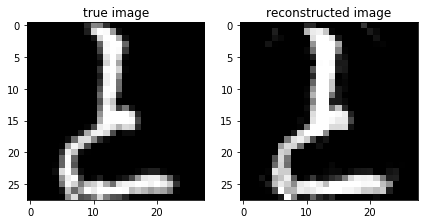

Epoch 1, latent size 774. LOSS: train 0.0102 test 0.0078.
0.0
1.0


Epoch 2, latent size 774. LOSS: train 0.0076 test 0.0063.
0.0
0.8991319


Epoch 3, latent size 764. LOSS: train 0.0074 test 0.0064.
0.0
0.971635


Epoch 4, latent size 764. LOSS: train 0.0062 test 0.0055.
0.0
0.9975571


Epoch 5, latent size 754. LOSS: train 0.0068 test 0.0061.
0.0
1.0


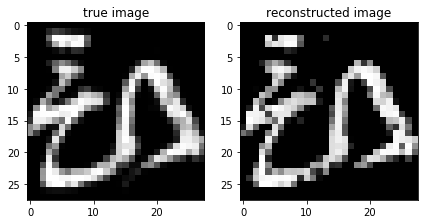

Epoch 6, latent size 754. LOSS: train 0.0058 test 0.0054.
0.0
1.0


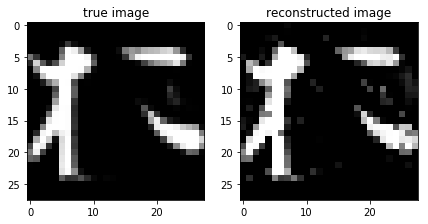

Epoch 7, latent size 744. LOSS: train 0.0065 test 0.0060.
0.0
1.0


Epoch 8, latent size 744. LOSS: train 0.0058 test 0.0055.
0.0
1.0


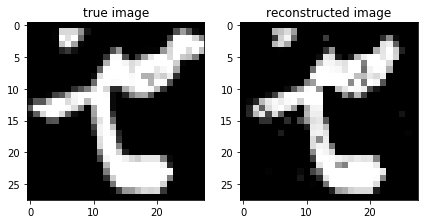

Epoch 9, latent size 734. LOSS: train 0.0063 test 0.0060.
0.0
1.0


Epoch 10, latent size 734. LOSS: train 0.0058 test 0.0056.
0.0
1.0


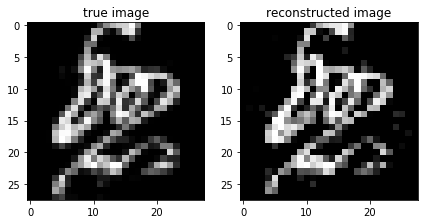

Epoch 11, latent size 724. LOSS: train 0.0066 test 0.0062.
0.0
1.0


Epoch 12, latent size 724. LOSS: train 0.0060 test 0.0058.
0.0
1.0


Epoch 13, latent size 714. LOSS: train 0.0065 test 0.0062.
0.0
1.0


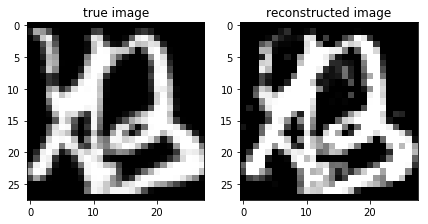

Epoch 14, latent size 714. LOSS: train 0.0061 test 0.0060.
0.0
1.0


Epoch 15, latent size 704. LOSS: train 0.0068 test 0.0065.
0.0
1.0


Epoch 16, latent size 704. LOSS: train 0.0063 test 0.0062.
0.0
1.0


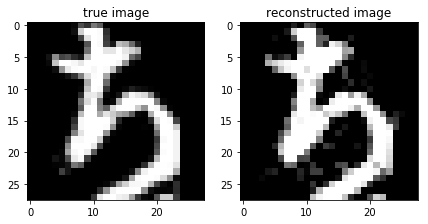

Epoch 17, latent size 694. LOSS: train 0.0068 test 0.0066.
0.0
1.0


Epoch 18, latent size 694. LOSS: train 0.0065 test 0.0064.
0.0
1.0


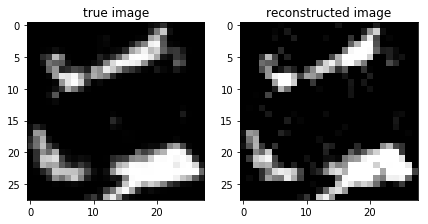

Epoch 19, latent size 684. LOSS: train 0.0071 test 0.0069.
0.0
1.0


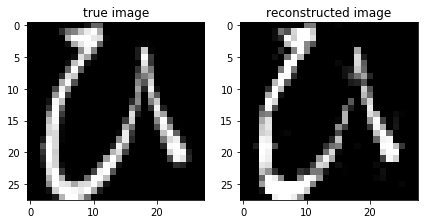

Epoch 20, latent size 684. LOSS: train 0.0067 test 0.0067.
0.0
1.0


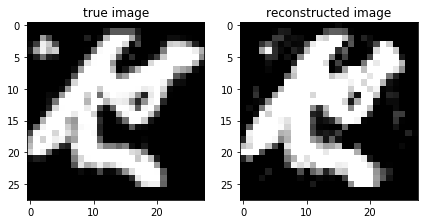

Epoch 21, latent size 674. LOSS: train 0.0073 test 0.0072.
0.0
1.0


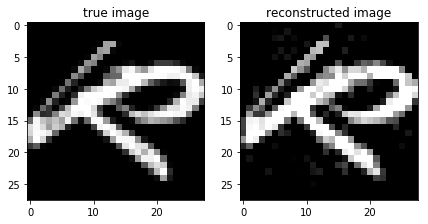

Epoch 22, latent size 674. LOSS: train 0.0070 test 0.0070.
0.0
1.0


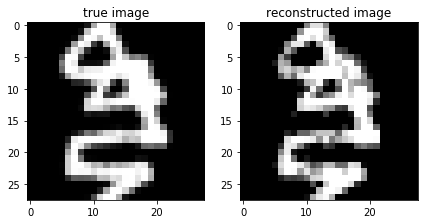

Epoch 23, latent size 664. LOSS: train 0.0073 test 0.0073.
0.0
1.0


Epoch 24, latent size 664. LOSS: train 0.0071 test 0.0072.
0.0
1.0


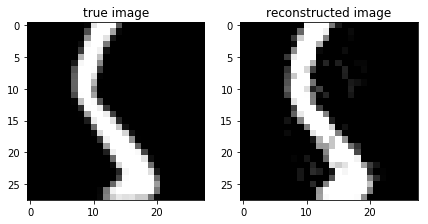

Epoch 25, latent size 654. LOSS: train 0.0076 test 0.0076.
0.0
1.0


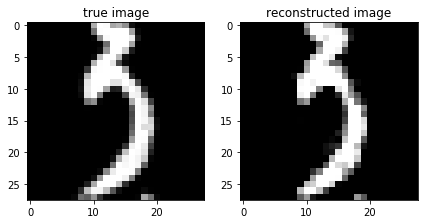

Epoch 26, latent size 654. LOSS: train 0.0073 test 0.0075.
0.0
1.0


Epoch 27, latent size 644. LOSS: train 0.0076 test 0.0077.
0.0
1.0


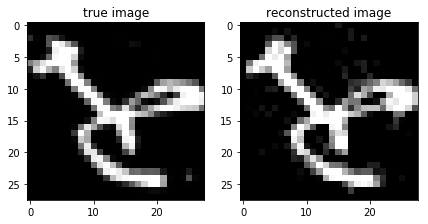

Epoch 28, latent size 644. LOSS: train 0.0074 test 0.0076.
0.0
1.0


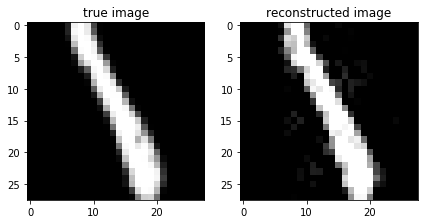

Epoch 29, latent size 634. LOSS: train 0.0078 test 0.0079.
0.0
1.0


Epoch 30, latent size 634. LOSS: train 0.0076 test 0.0078.
0.0
1.0


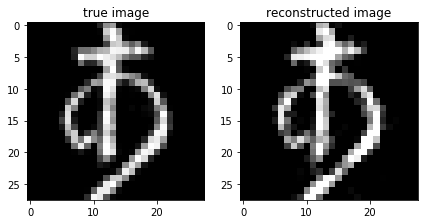

Epoch 31, latent size 624. LOSS: train 0.0083 test 0.0083.
0.0
1.0


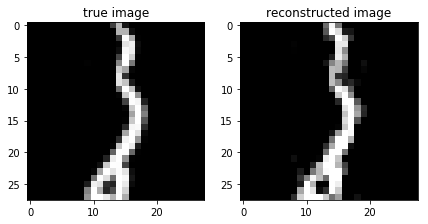

Epoch 32, latent size 624. LOSS: train 0.0081 test 0.0083.
0.0
1.0


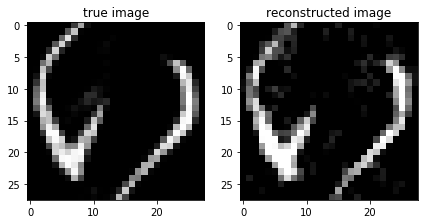

Epoch 33, latent size 614. LOSS: train 0.0085 test 0.0086.
0.0
1.0


Epoch 34, latent size 614. LOSS: train 0.0083 test 0.0086.
0.0
1.0


Epoch 35, latent size 604. LOSS: train 0.0087 test 0.0088.
0.0
1.0


Epoch 36, latent size 604. LOSS: train 0.0085 test 0.0087.
0.0
1.0


Epoch 37, latent size 594. LOSS: train 0.0095 test 0.0096.
0.0
1.0


Epoch 38, latent size 594. LOSS: train 0.0092 test 0.0095.
0.0
1.0


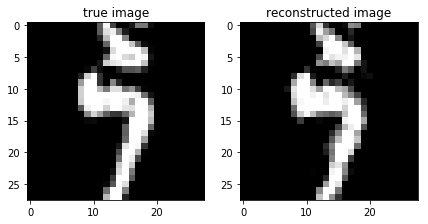

Epoch 39, latent size 584. LOSS: train 0.0097 test 0.0099.
0.0
1.0


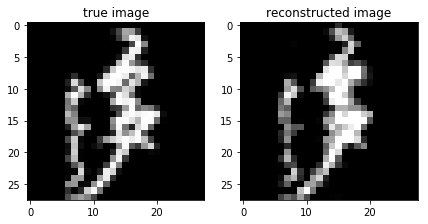

Epoch 40, latent size 584. LOSS: train 0.0095 test 0.0098.
0.0
1.0


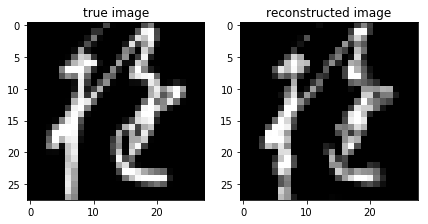

Epoch 41, latent size 574. LOSS: train 0.0099 test 0.0101.
0.0
1.0


Epoch 42, latent size 574. LOSS: train 0.0097 test 0.0099.
0.0
1.0


Epoch 43, latent size 564. LOSS: train 0.0102 test 0.0104.
0.0
1.0


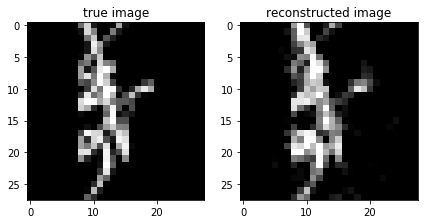

Epoch 44, latent size 564. LOSS: train 0.0100 test 0.0103.
0.0
1.0


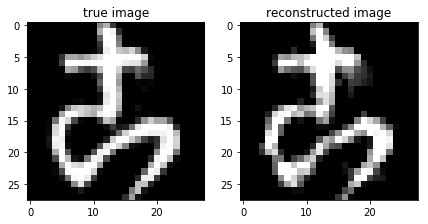

Epoch 45, latent size 554. LOSS: train 0.0105 test 0.0107.
0.0
1.0


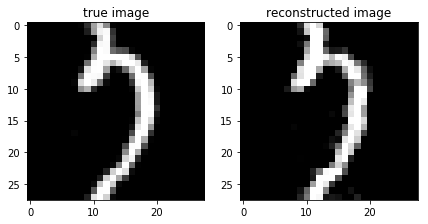

Epoch 46, latent size 554. LOSS: train 0.0103 test 0.0106.
0.0
1.0


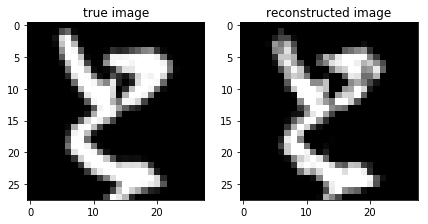

Epoch 47, latent size 544. LOSS: train 0.0111 test 0.0113.
0.0
1.0


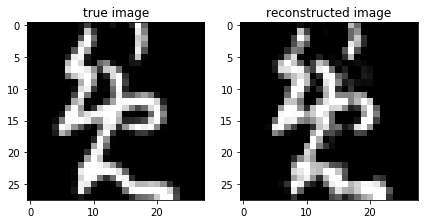

Epoch 48, latent size 544. LOSS: train 0.0108 test 0.0111.
0.0
1.0


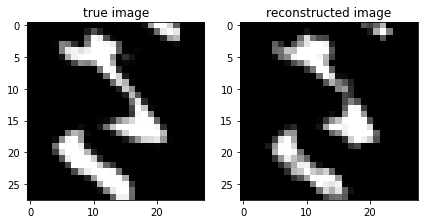

Epoch 49, latent size 534. LOSS: train 0.0116 test 0.0118.
0.0
1.0


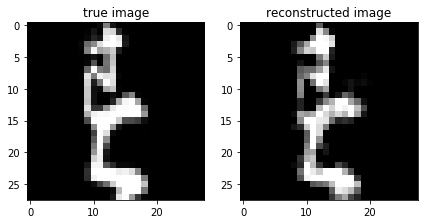

Epoch 50, latent size 534. LOSS: train 0.0113 test 0.0116.
0.0
1.0


Epoch 51, latent size 524. LOSS: train 0.0122 test 0.0124.
0.0
1.0


Epoch 52, latent size 524. LOSS: train 0.0118 test 0.0122.
0.0
1.0


Epoch 53, latent size 514. LOSS: train 0.0121 test 0.0124.
0.0
1.0


Epoch 54, latent size 514. LOSS: train 0.0119 test 0.0123.
0.0
1.0


Epoch 55, latent size 504. LOSS: train 0.0127 test 0.0130.
0.0
1.0


Epoch 56, latent size 504. LOSS: train 0.0125 test 0.0129.
0.0
1.0


Epoch 57, latent size 494. LOSS: train 0.0133 test 0.0136.
0.0
1.0


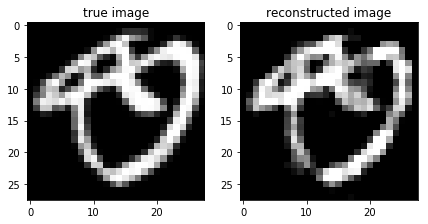

Epoch 58, latent size 494. LOSS: train 0.0131 test 0.0135.
0.0
1.0


Epoch 59, latent size 484. LOSS: train 0.0141 test 0.0144.
0.0
1.0


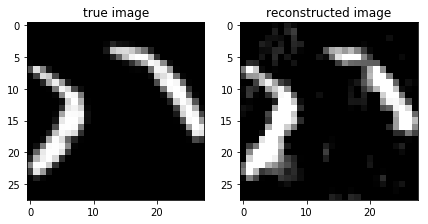

Epoch 60, latent size 484. LOSS: train 0.0139 test 0.0143.
0.0
1.0


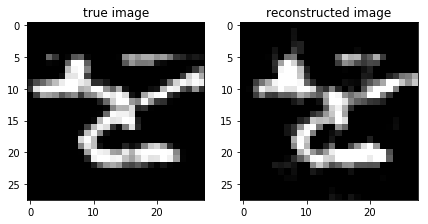

Epoch 61, latent size 474. LOSS: train 0.0143 test 0.0146.
0.0
1.0


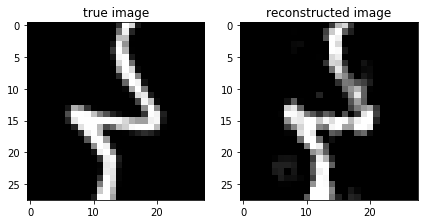

Epoch 62, latent size 474. LOSS: train 0.0141 test 0.0145.
0.0
1.0


Epoch 63, latent size 464. LOSS: train 0.0146 test 0.0149.
0.0
1.0


Epoch 64, latent size 464. LOSS: train 0.0144 test 0.0149.
0.0
1.0


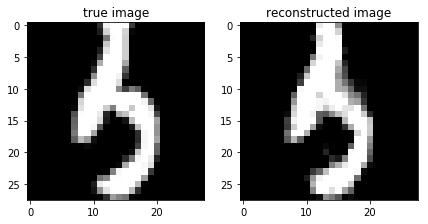

Epoch 65, latent size 454. LOSS: train 0.0155 test 0.0158.
0.0
1.0


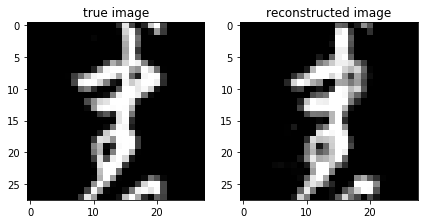

Epoch 66, latent size 454. LOSS: train 0.0152 test 0.0156.
0.0
1.0


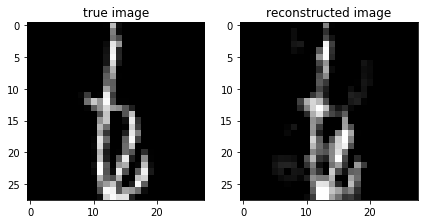

Epoch 67, latent size 444. LOSS: train 0.0159 test 0.0161.
0.0
1.0


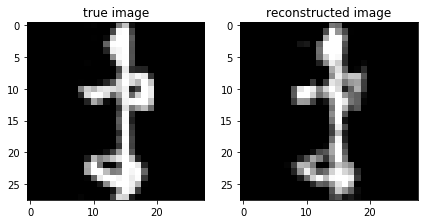

Epoch 68, latent size 444. LOSS: train 0.0154 test 0.0159.
0.0
1.0


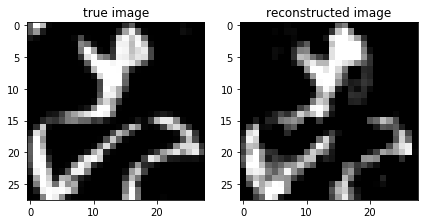

Epoch 69, latent size 434. LOSS: train 0.0159 test 0.0163.
0.0
1.0


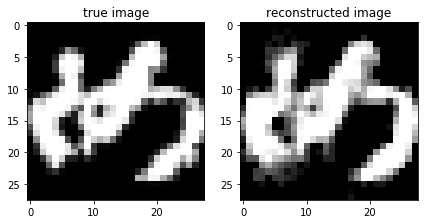

Epoch 70, latent size 434. LOSS: train 0.0156 test 0.0161.
0.0
1.0


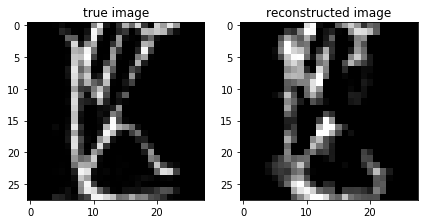

Epoch 71, latent size 424. LOSS: train 0.0170 test 0.0172.
0.0
1.0


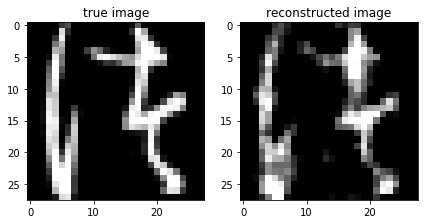

Epoch 72, latent size 424. LOSS: train 0.0165 test 0.0170.
0.0
1.0


Epoch 73, latent size 414. LOSS: train 0.0172 test 0.0175.
0.0
1.0


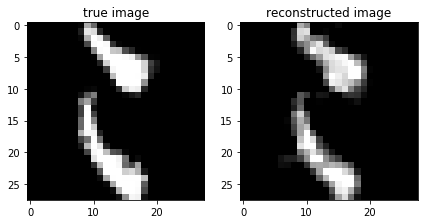

Epoch 74, latent size 414. LOSS: train 0.0168 test 0.0173.
0.0
1.0


Epoch 75, latent size 404. LOSS: train 0.0173 test 0.0177.
0.0
1.0


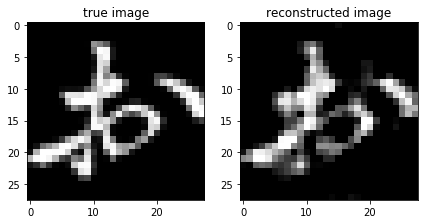

Epoch 76, latent size 404. LOSS: train 0.0170 test 0.0176.
0.0
1.0


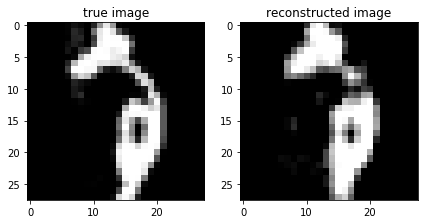

Epoch 77, latent size 394. LOSS: train 0.0182 test 0.0187.
0.0
1.0


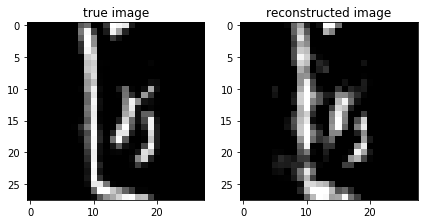

Epoch 78, latent size 394. LOSS: train 0.0178 test 0.0184.
0.0
1.0


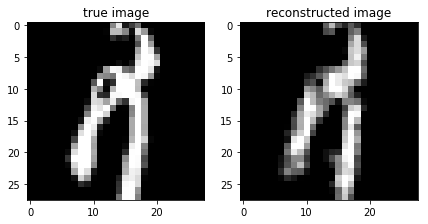

Epoch 79, latent size 384. LOSS: train 0.0195 test 0.0197.
0.0
1.0


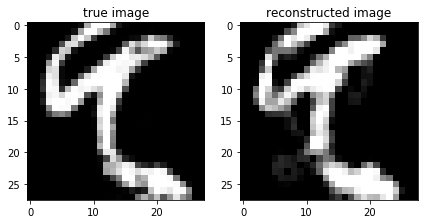

Epoch 80, latent size 384. LOSS: train 0.0189 test 0.0195.
0.0
1.0


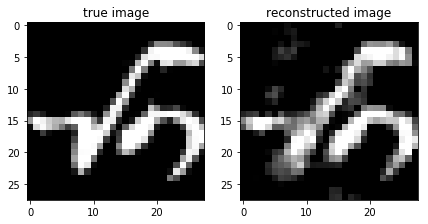

Epoch 81, latent size 374. LOSS: train 0.0191 test 0.0196.
0.0
1.0


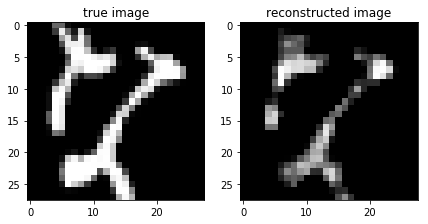

Epoch 82, latent size 374. LOSS: train 0.0188 test 0.0194.
0.0
1.0


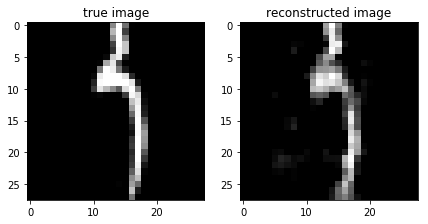

Epoch 83, latent size 364. LOSS: train 0.0199 test 0.0204.
0.0
1.0


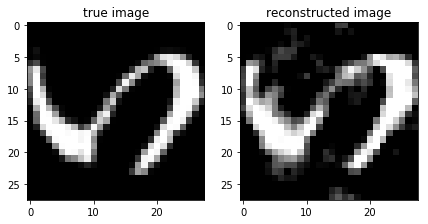

Epoch 84, latent size 364. LOSS: train 0.0195 test 0.0202.
0.0
1.0


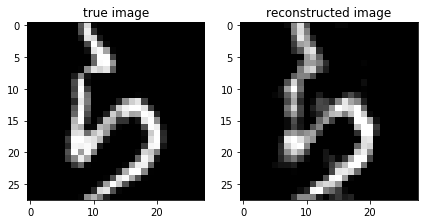

Epoch 85, latent size 354. LOSS: train 0.0207 test 0.0211.
0.0
1.0


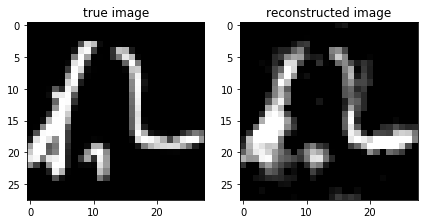

Epoch 86, latent size 354. LOSS: train 0.0203 test 0.0209.
0.0
1.0


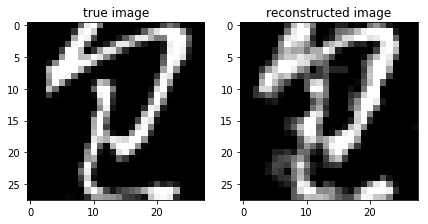

Epoch 87, latent size 344. LOSS: train 0.0213 test 0.0217.
0.0
1.0


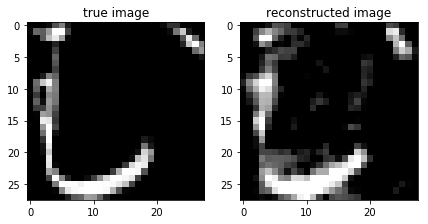

Epoch 88, latent size 344. LOSS: train 0.0209 test 0.0215.
0.0
1.0


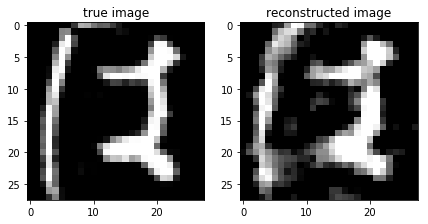

Epoch 89, latent size 334. LOSS: train 0.0228 test 0.0231.
0.0
1.0


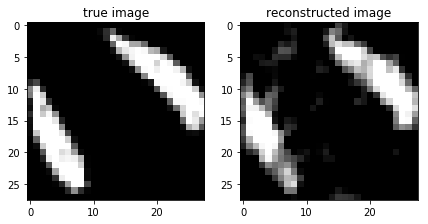

Epoch 90, latent size 334. LOSS: train 0.0223 test 0.0229.
0.0
1.0


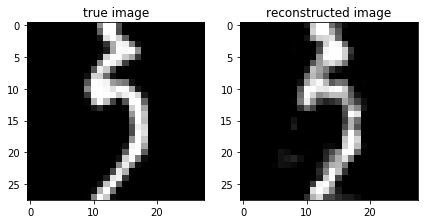

Epoch 91, latent size 324. LOSS: train 0.0234 test 0.0238.
0.0
1.0


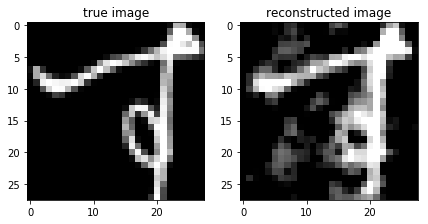

Epoch 92, latent size 324. LOSS: train 0.0229 test 0.0235.
0.0
1.0


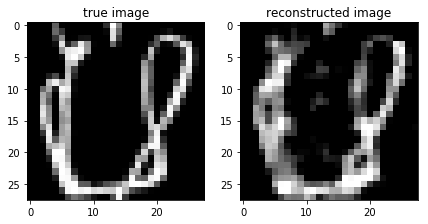

Epoch 93, latent size 314. LOSS: train 0.0249 test 0.0251.
0.0
1.0


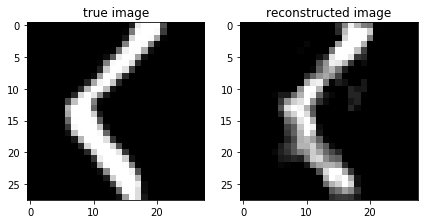

Epoch 94, latent size 314. LOSS: train 0.0243 test 0.0249.
0.0
1.0


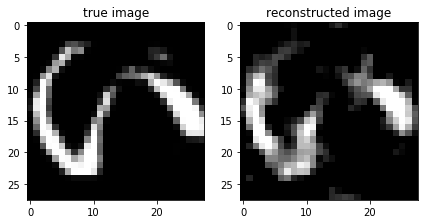

Epoch 95, latent size 304. LOSS: train 0.0248 test 0.0253.
0.0
0.9742698


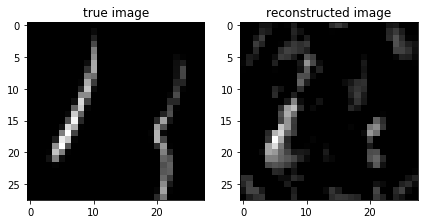

Epoch 96, latent size 304. LOSS: train 0.0245 test 0.0251.
0.0
1.0


Epoch 97, latent size 294. LOSS: train 0.0252 test 0.0256.
0.0
1.0


Epoch 98, latent size 294. LOSS: train 0.0247 test 0.0253.
0.0
1.0


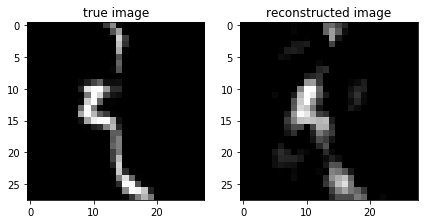

Epoch 99, latent size 284. LOSS: train 0.0259 test 0.0263.
0.0
1.0


Epoch 100, latent size 284. LOSS: train 0.0254 test 0.0260.
0.0
1.0


Epoch 101, latent size 274. LOSS: train 0.0275 test 0.0278.
0.0
1.0


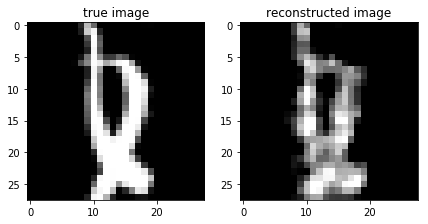

Epoch 102, latent size 274. LOSS: train 0.0269 test 0.0276.
0.0
1.0


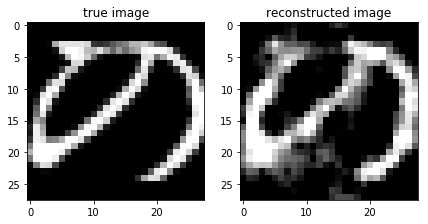

Epoch 103, latent size 264. LOSS: train 0.0279 test 0.0283.
0.0
1.0


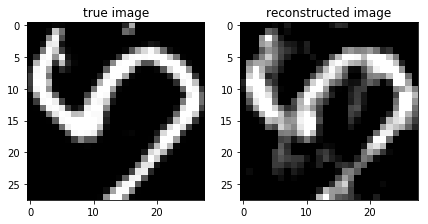

Epoch 104, latent size 264. LOSS: train 0.0274 test 0.0281.
0.0
1.0


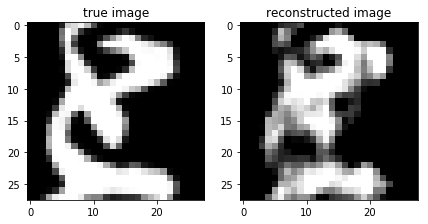

Epoch 105, latent size 254. LOSS: train 0.0295 test 0.0298.
0.0
1.0


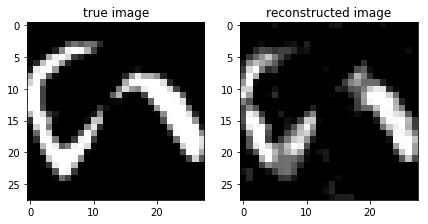

Epoch 106, latent size 254. LOSS: train 0.0289 test 0.0295.
0.0
1.0


Epoch 107, latent size 244. LOSS: train 0.0308 test 0.0311.
0.0
1.0


Epoch 108, latent size 244. LOSS: train 0.0302 test 0.0308.
0.0
1.0


Epoch 109, latent size 234. LOSS: train 0.0316 test 0.0320.
0.0
1.0


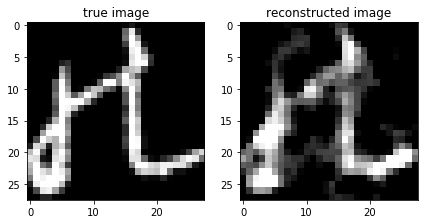

Epoch 110, latent size 234. LOSS: train 0.0312 test 0.0318.
0.0
1.0


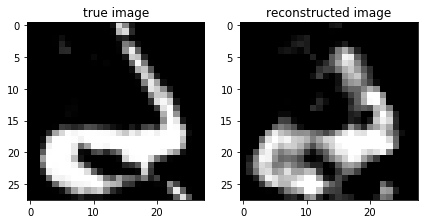

Epoch 111, latent size 224. LOSS: train 0.0330 test 0.0332.
0.0
1.0


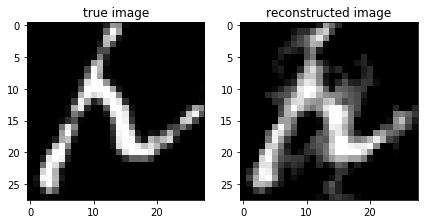

Epoch 112, latent size 224. LOSS: train 0.0324 test 0.0330.
0.0
1.0


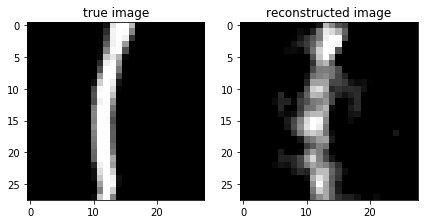

Epoch 113, latent size 214. LOSS: train 0.0342 test 0.0344.
0.0
1.0


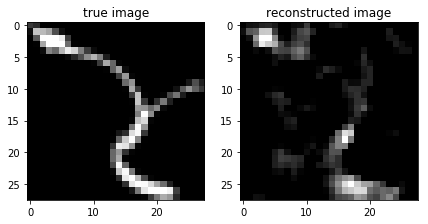

Epoch 114, latent size 214. LOSS: train 0.0335 test 0.0341.
0.0
1.0


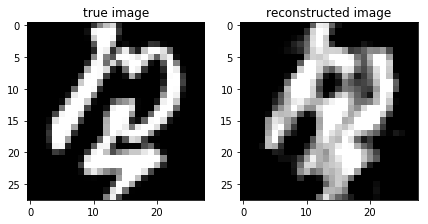

Epoch 115, latent size 204. LOSS: train 0.0366 test 0.0367.
0.0
1.0


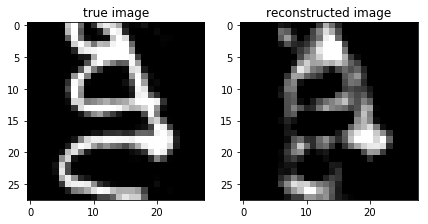

Epoch 116, latent size 204. LOSS: train 0.0359 test 0.0363.
0.0
1.0


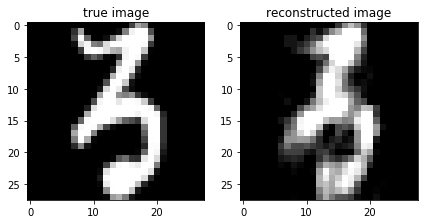

Epoch 117, latent size 194. LOSS: train 0.0374 test 0.0377.
0.0
1.0


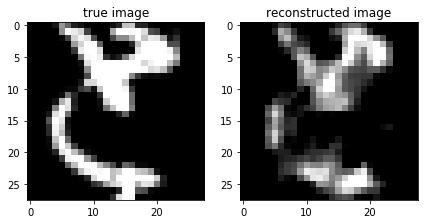

Epoch 118, latent size 194. LOSS: train 0.0368 test 0.0374.
0.0
1.0


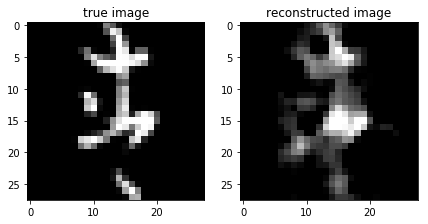

Epoch 119, latent size 184. LOSS: train 0.0382 test 0.0382.
0.0
1.0


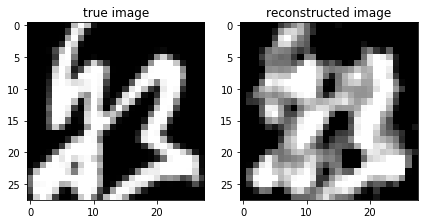

Epoch 120, latent size 184. LOSS: train 0.0373 test 0.0378.
0.0
1.0


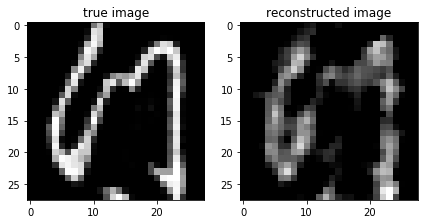

Epoch 121, latent size 174. LOSS: train 0.0400 test 0.0397.
0.0
1.0


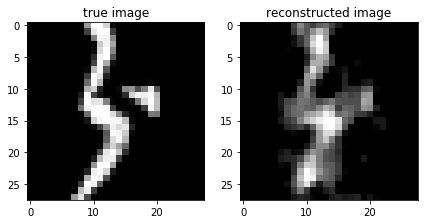

Epoch 122, latent size 174. LOSS: train 0.0388 test 0.0391.
0.0
1.0


Epoch 123, latent size 164. LOSS: train 0.0398 test 0.0398.
0.0
1.0


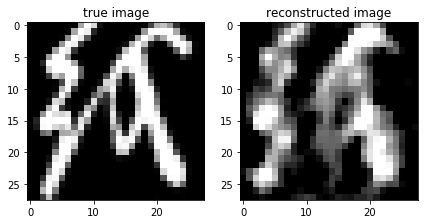

Epoch 124, latent size 164. LOSS: train 0.0392 test 0.0395.
0.0
1.0


Epoch 125, latent size 154. LOSS: train 0.0426 test 0.0423.
0.0
1.0


Epoch 126, latent size 154. LOSS: train 0.0415 test 0.0417.
0.0
1.0


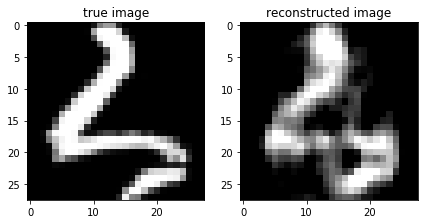

Epoch 127, latent size 144. LOSS: train 0.0446 test 0.0442.
0.0
1.0


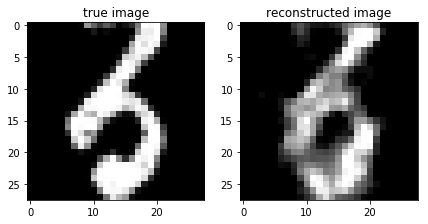

Epoch 128, latent size 144. LOSS: train 0.0433 test 0.0434.
0.0
1.0


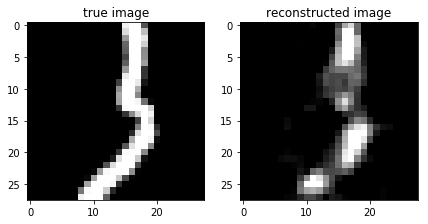

Epoch 129, latent size 134. LOSS: train 0.0449 test 0.0446.
0.0
0.9110978


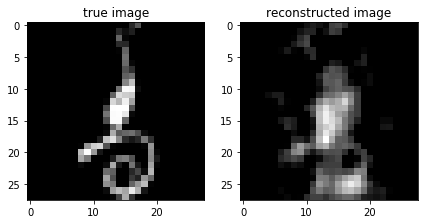

Epoch 130, latent size 134. LOSS: train 0.0440 test 0.0442.
0.0
1.0


Epoch 131, latent size 124. LOSS: train 0.0463 test 0.0458.
0.0
1.0


Epoch 132, latent size 124. LOSS: train 0.0450 test 0.0451.
0.0
0.5963761


Epoch 133, latent size 114. LOSS: train 0.0452 test 0.0451.
0.0
1.0


Epoch 134, latent size 114. LOSS: train 0.0444 test 0.0448.
0.0
1.0


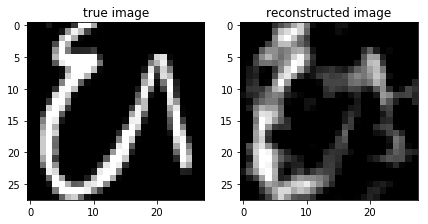

Epoch 135, latent size 104. LOSS: train 0.0462 test 0.0465.
0.0
1.0


Epoch 136, latent size 104. LOSS: train 0.0457 test 0.0461.
0.0
1.0


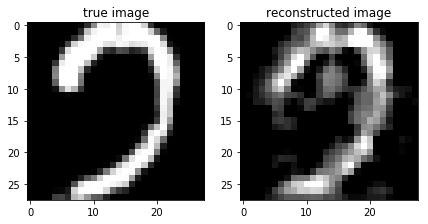

Epoch 137, latent size 94. LOSS: train 0.0524 test 0.0513.
0.0
1.0


Epoch 138, latent size 94. LOSS: train 0.0508 test 0.0506.
0.0
0.665623


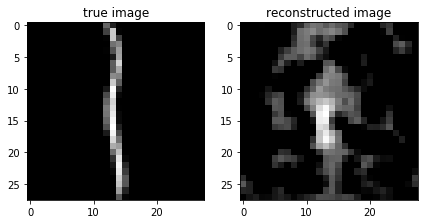

Epoch 139, latent size 84. LOSS: train 0.0549 test 0.0539.
0.0
1.0


Epoch 140, latent size 84. LOSS: train 0.0537 test 0.0534.
0.0
0.6445375


Epoch 141, latent size 74. LOSS: train 0.0576 test 0.0564.
0.0
1.0


Epoch 142, latent size 74. LOSS: train 0.0561 test 0.0558.
0.0
1.0


Epoch 143, latent size 64. LOSS: train 0.0634 test 0.0615.
0.0
1.0


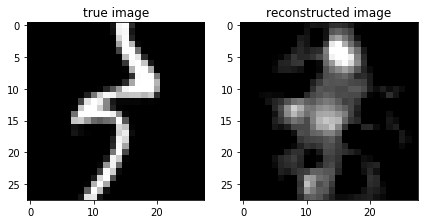

Epoch 144, latent size 64. LOSS: train 0.0617 test 0.0610.
0.0
1.0


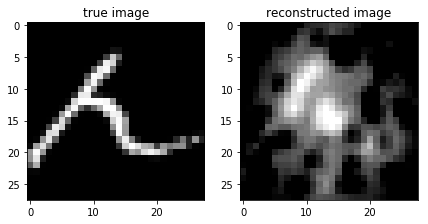

Epoch 145, latent size 54. LOSS: train 0.0640 test 0.0622.
0.0
1.0


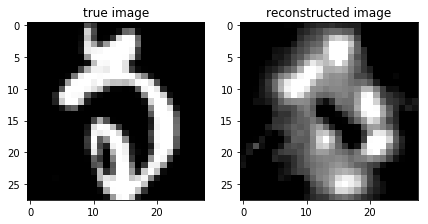

Epoch 146, latent size 54. LOSS: train 0.0621 test 0.0615.
0.0
0.7322735


In [11]:
data_dim = 784

start_size = data_dim
target_size = 54
epochs_per_step = 2
step_size = 10

perf_per_latent = dict()

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
criterion = nn.MSELoss()

history = []
epoch_counter = 0
current_latent_size = start_size

for epoch in range(0, int((start_size - target_size) * epochs_per_step / step_size + epochs_per_step - 1)):
    train_obj = AvgrageMeter()
    test_obj = AvgrageMeter()

    # Reduce latent size every num_epoch epochs
    if epoch_counter == epochs_per_step-1:
        epoch_counter = 0

        model.reduce_latent_size(step_size)
        perf_per_latent[current_latent_size] = history[-1][1]
        current_latent_size -= step_size
    else:
        epoch_counter += 1

    for images, labels in train_loader:
        predictions = model(images)
        loss = criterion(predictions, images)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_obj.update(loss.item(), len(images))

    for images, labels in test_loader:
        predictions = model(images)
        loss = criterion(predictions, images)

        test_obj.update(loss.item(), len(images))

    print(f"Epoch {epoch}, latent size {current_latent_size}. LOSS: train {train_obj.avg:.4f} test {test_obj.avg:.4f}.")
    history.append((train_obj.avg, test_obj.avg))


    # Printing and plotting
    index = np.random.randint(len(images))
    prediction = predictions[index].detach().numpy().reshape(28, 28)
    true = images[index].detach().numpy().reshape(28, 28)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 14))

    ax1.set_title("true image")
    ax1.imshow(true, cmap='gray')

    ax2.set_title("reconstructed image")
    print(np.min(prediction))
    print(np.max(prediction))
    ax2.imshow(prediction, cmap='gray')
    plt.show()

In [12]:
latent_train, latent_test = make_latent_dataset(model)

MemoryError: 

In [ ]:
model, history = train_classifier(latent_train, latent_test, num_epochs=40, learning_rate=1e-4, weight_decay=1e-5, batch_size=64, verbose=False)

In [ ]:
history = np.array(history)
plt.title("Objective (MSE)")
plt.plot(history[:,0], label="train")
plt.plot(history[:,1], label="test")
plt.legend()
plt.show()

In [ ]:
plt.plot(perf_per_latent.keys(), perf_per_latent.values())